In [1]:
#라이브러리 버전 확인
import pandas
import tensorflow

print(pandas.__version__)
print(tensorflow.__version__)

1.3.3
2.6.0


In [2]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 데이터 불러오기

In [3]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
#아래 pd.to_datetime을 하지 않으면 timestamp형식으로 나와서 알아보기에 불편함
data["Time"] = pd.to_datetime(data["Time"], unit= "s")
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 userid와 시간 순서로 정렬
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


# 전처리

In [4]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

중복안된 유저 id 갯수 6040, 아이템 갯수 3706개

In [5]:
# size() 메서드는 전체 원소의 수를 반환할 때 사용
user_length = data.groupby('UserId').size()
user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

6040개의 row. 유저당 몇 편을 봤는지 확인가능

In [6]:
user_length.median(), user_length.mean()

(96.0, 165.5975165562914)

영화본 중앙값 96, 평균 165편

In [7]:
user_length.min(), user_length.max()

(20, 2314)

최소본 사람 20편, 최대로 본 사람 2314편

In [8]:
user_length.quantile(0.97)

693.1499999999996

유저길이의 97.5%는 1045. max값의 차이가 너무 크므로 확인필요

In [9]:
long_user = user_length[user_length==2314].index[0]
data[data['UserId']==long_user]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,2000-08-03 20:09:52
697168,4169,2617,4,2000-08-03 20:09:52
697185,4169,2628,4,2000-08-03 20:09:52
697219,4169,2653,4,2000-08-03 20:09:52
697275,4169,423,3,2000-08-03 20:09:52
...,...,...,...,...
697882,4169,3754,2,2002-06-15 20:52:27
695702,4169,1413,3,2002-06-15 21:03:51
697358,4169,494,4,2002-06-15 21:16:00
695945,4169,1804,2,2002-06-15 21:16:23


마지막열에 가까워질수록 비교적 정상적인 결과가 나오나, 처음 5번 이상은 같은 시간에 연달아 클릭한 것이 나타남

In [10]:
#cumsum은 누적합을 구할 때 사용
# 97 퍼센트를 한 특별한 이유는 없지만, 보통 신뢰할 수 있는 확률을 p-value로 하여
# 95 퍼센트를 기준으로 하기에 그보다 조금 더 높은 97퍼센트를 기준으로 함
length_count = user_length.groupby(user_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_97 = length_percent_cumsum[length_percent_cumsum < 0.97]

length_percent_cumsum_97

20     0.014238
21     0.029305
22     0.042053
23     0.055464
24     0.068874
         ...   
684    0.969205
685    0.969371
686    0.969536
688    0.969702
689    0.969868
Length: 589, dtype: float64

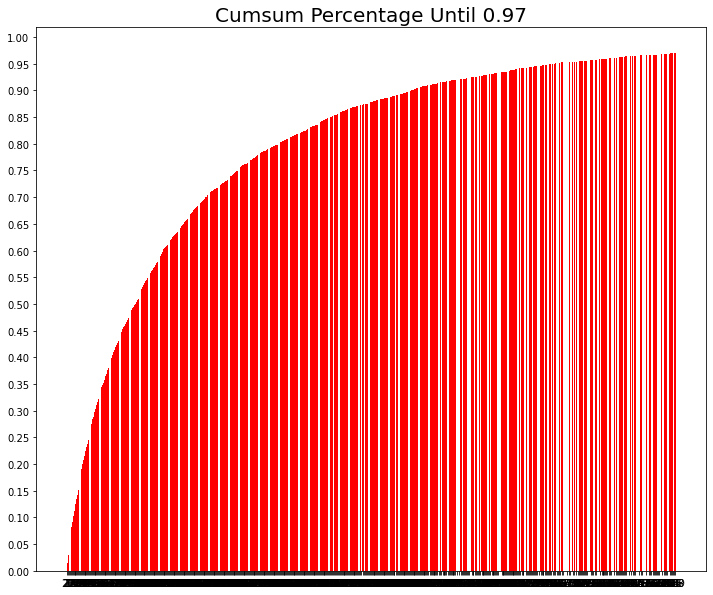

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_97.index,
        height=length_percent_cumsum_97, color='red')
plt.xticks(length_percent_cumsum_97.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.97', size=20)
plt.show()

97%까지 분포 누적합 시각화

In [12]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


약 3년치 데이터 확인

In [13]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

날짜끼리의 차이를 사용하고 싶을 경우 datetime.timedelta(날짜의 차이)
를 사용해야하지만, 3년 데이터를 모두 사용할 것이기에 필요하지 않음

### Data Cleansing

In [14]:
# shortest에 입력된 값에따라 n명만 클릭한 항목 제거
#least_click에 입력된 값에 따라 전체 클릭수가 n명 이상인 값만 data에 반영
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data

#클릭한 사람이 shortest값 미만일경우 데이터에서 배제
def cleanse_short_session(data: pd.DataFrame, shortest):
    user_len = data.groupby('UserId').size()
    user_use = user_len[user_len >= shortest].index
    # isin 메서드는 괄호안에 들어간값이 데이터에 있는지 확인하고 True, False로 반환
    #이 경우에는 트루만 출력되고 펄스는 출력되지 아니함
    data = data[data['UserId'].isin(user_use)]
    return data

#전체 클릭한 사람의 수가 least_click 이상인 값만 데이터에 반영
def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [15]:
#유저가 1명만 클릭했거나, 전체 클릭수가 5이하인 것은 데이터에 반영하지 않음
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [16]:
#가장 오래된 데이터와 가장 최신의 데이터를 알아보기위해 time순으로 정렬
data = data.sort_values(by=['Time'])
data

,UserId,ItemId,Rating,Time
1000138,6040,858,4,2000-04-25 23:05:32
999873,6040,593,5,2000-04-25 23:05:54
1000153,6040,2384,4,2000-04-25 23:05:54
1000007,6040,1961,4,2000-04-25 23:06:17
1000192,6040,2019,5,2000-04-25 23:06:17
...,...,...,...,...
825793,4958,2399,1,2003-02-28 17:45:38
825438,4958,1407,5,2003-02-28 17:47:23
825724,4958,3264,4,2003-02-28 17:49:08
825731,4958,2634,3,2003-02-28 17:49:08


In [17]:
#날짜에따라 데이터를 나누는 함수. test, validation을 나누기 위해 사용
#data의 형식은 판다스 데이터프레임, n_days의 형식은 정수형(int)
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    user_last_time = data.groupby('UserId')['Time'].max()
    user_in_train = user_last_time[user_last_time < final_time - dt.timedelta(n_days)].index
    user_in_test = user_last_time[user_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(user_in_train)]
    after_date = data[data['UserId'].isin(user_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [18]:
#전체 34개월중 3, 5개월씩을 각각 test, val set으로 둠
tr, test = split_by_date(data, n_days=90)
tr, val = split_by_date(tr, n_days=150)

In [19]:
# data에 대한 정보 확인 함수
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [20]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 844530
	 Sessions: 5653
	 Items: 3416
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-07-02 15:40:10

* valid Set Stats Info
	 Events: 57381
	 Sessions: 154
	 Items: 3137
	 First Time : 2000-04-27 16:38:08
	 Last Time : 2002-11-30 13:47:32

* test Set Stats Info
	 Events: 97700
	 Sessions: 233
	 Items: 3279
	 First Time : 2000-05-01 11:15:13
	 Last Time : 2003-02-28 17:49:50



In [21]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

# id2idx에 없는 아이템은 모르는 값(-1) 처리 해주기
#get 함수에 키값을 입력했을 때 딕셔너리의 밸류값을 출력함.
#get함수로 가져오기 위해 값을 입력했지만 키 값이 존재하지 않을 경우 None을 반환함
#이 경우에는 x가 입력되었을 때 default 값인 -1을 출력(키가 존재한다면 -1이 아닌 원래 값 출력됨)
def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [22]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

# 미니배치 구성

### SessionDataset

In [23]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        각 섹션에서 첫번째 클릭한 인덱스로 돌아감
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [24]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
1000138,6040,858,4,2000-04-25 23:05:32,0
999873,6040,593,5,2000-04-25 23:05:54,1
1000153,6040,2384,4,2000-04-25 23:05:54,2
1000007,6040,1961,4,2000-04-25 23:06:17,3
1000192,6040,2019,5,2000-04-25 23:06:17,4
999868,6040,573,4,2000-04-25 23:07:36,5
999877,6040,1419,3,2000-04-25 23:07:36,6
999920,6040,213,5,2000-04-25 23:07:36,7
999967,6040,3111,5,2000-04-25 23:07:36,8
999980,6040,3505,4,2000-04-25 23:07:36,9


In [25]:
tr_dataset.click_offsets

array([     0,     53,    182, ..., 844066, 844189, 844530], dtype=int32)

In [26]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 5650, 5651, 5652])

### SessionDataLoader

In [27]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  
        """
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  #세션에서 길이가 제일 짧은 값
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옴
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옴
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옴
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update함
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻 mask에 기록

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌림
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [28]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=8)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
1000138,6040,858,4,2000-04-25 23:05:32,0
999873,6040,593,5,2000-04-25 23:05:54,1
1000153,6040,2384,4,2000-04-25 23:05:54,2
1000007,6040,1961,4,2000-04-25 23:06:17,3
1000192,6040,2019,5,2000-04-25 23:06:17,4
999868,6040,573,4,2000-04-25 23:07:36,5
999877,6040,1419,3,2000-04-25 23:07:36,6
999920,6040,213,5,2000-04-25 23:07:36,7
999967,6040,3111,5,2000-04-25 23:07:36,8
999980,6040,3505,4,2000-04-25 23:07:36,9


In [29]:
iter_ex = iter(tr_data_loader)

In [30]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  0  53 177 210 228 392 439 464]
Label Item Idx are :       [  1  54 106 211 229 393 440 465]
Previous Masked Input Idx are []


# 모델구성

In [31]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [32]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [33]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [34]:
#모델에 사용할 파라미터 class형식으로
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_users = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

# 예시 : args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)

In [35]:
# train 셋으로 학습하면서 valid 셋으로 검증
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화함

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옴
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옴
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드
                                             # train과 거의 같지만 mrr, recall을 구하는 라인 존재
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)
        pred = model.predict(input_ohe, batch_size=args.batch_size)
#         pred_arg = tf.nn.top_k(pred, k=124, sorted=True)[1]  # softmax 값이 큰 순서대로 sorting
        pred_arg = tf.argsort(pred, direction='DESCENDING')
    
        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [36]:
#모델 테스트 함수
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

# 모델학습

###### 1차시도 
배치사이즈 128, hsz 50, drop_rate=0.1, lr = 0.001, epochs=5(고정)

In [37]:
args1 = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model1 = create_model(args1)
train_model(model1, args1)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(128, 1, 3416)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    520200    
_________________________________________________________________
dropout (Dropout)            (128, 50)                 0         
_________________________________________________________________
dense (Dense)                (128, 3416)               174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


Evaluation:  33%|███▎      | 146/447 [01:22<02:49,  1.78it/s]


	 - Recall@20 epoch 1: 0.146030
	 - MRR@20    epoch 1: 0.031699



Evaluation:  33%|███▎      | 146/447 [01:19<02:43,  1.84it/s]


	 - Recall@20 epoch 2: 0.205212
	 - MRR@20    epoch 2: 0.045501



Evaluation:  33%|███▎      | 146/447 [01:18<02:41,  1.86it/s]


	 - Recall@20 epoch 3: 0.221426
	 - MRR@20    epoch 3: 0.050946



Evaluation:  33%|███▎      | 146/447 [01:18<02:41,  1.87it/s]


	 - Recall@20 epoch 4: 0.228756
	 - MRR@20    epoch 4: 0.054320



Evaluation:  33%|███▎      | 146/447 [01:18<02:41,  1.86it/s]

	 - Recall@20 epoch 5: 0.231164
	 - MRR@20    epoch 5: 0.056324



정확도가 올라가는 속도가 너무 낮고, loss개선 속도가 미미함.
러닝레이트가 낮아서 발생한 것이라 생각하고 러닝레이트를 확 늘려봐야 할 것으로 보임

###### 2차시도
배치사이즈 128, hsz 50, drop_rate=0.1, lr = 0.005, epochs=5(고정)

In [38]:
args2 = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.005, epochs=5, k=20)
model2 = create_model(args2)
train_model(model2, args2)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(128, 1, 3416)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    520200    
_________________________________________________________________
dropout_1 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_1 (Dense)              (128, 3416)               174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


Evaluation:  33%|███▎      | 146/447 [01:19<02:43,  1.84it/s]


	 - Recall@20 epoch 1: 0.219285
	 - MRR@20    epoch 1: 0.051043



Evaluation:  33%|███▎      | 146/447 [01:17<02:40,  1.88it/s]


	 - Recall@20 epoch 2: 0.228596
	 - MRR@20    epoch 2: 0.055337



Evaluation:  33%|███▎      | 146/447 [01:18<02:40,  1.87it/s]


	 - Recall@20 epoch 3: 0.229399
	 - MRR@20    epoch 3: 0.055939



Evaluation:  33%|███▎      | 146/447 [01:17<02:40,  1.87it/s]


	 - Recall@20 epoch 4: 0.228221
	 - MRR@20    epoch 4: 0.057089



Evaluation:  33%|███▎      | 146/447 [01:18<02:41,  1.87it/s]

	 - Recall@20 epoch 5: 0.224208
	 - MRR@20    epoch 5: 0.055971



정확도가 0에서 벗어나는 것은 빨라졌으나 정확도가 감소하기 시작하는 부분이 존재.
hidden state인 hsz를 400으로 변경 후 재실행

###### 3차시도
배치사이즈 128, hsz 400, drop_rate=0.1, lr = 0.005, epochs=5(고정)

In [39]:
args3 = Args(tr, val, test, batch_size=128, hsz=400, drop_rate=0.1, lr=0.005, epochs=5, k=20)
model3 = create_model(args3)
train_model(model3, args3)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(128, 1, 3416)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 400), (128, 400)]  4581600   
_________________________________________________________________
dropout_2 (Dropout)          (128, 400)                0         
_________________________________________________________________
dense_2 (Dense)              (128, 3416)               1369816   
Total params: 5,951,416
Trainable params: 5,951,416
Non-trainable params: 0
_________________________________________________________________


Evaluation:  33%|███▎      | 146/447 [01:17<02:39,  1.89it/s]


	 - Recall@20 epoch 1: 0.225118
	 - MRR@20    epoch 1: 0.058160



Evaluation:  33%|███▎      | 146/447 [01:18<02:40,  1.87it/s]


	 - Recall@20 epoch 2: 0.206443
	 - MRR@20    epoch 2: 0.053468



Evaluation:  33%|███▎      | 146/447 [01:18<02:41,  1.87it/s]


	 - Recall@20 epoch 3: 0.192102
	 - MRR@20    epoch 3: 0.047982



Evaluation:  33%|███▎      | 146/447 [01:19<02:42,  1.85it/s]


	 - Recall@20 epoch 4: 0.186697
	 - MRR@20    epoch 4: 0.048125



Evaluation:  33%|███▎      | 146/447 [01:18<02:42,  1.85it/s]

	 - Recall@20 epoch 5: 0.183005
	 - MRR@20    epoch 5: 0.045733



hsz를 늘렸음에도 정확도 개선은 크게 나아지지 않음. 드롭 레이트는 과적합이 나올 경우 변화시키려 했으나, 적용.
여전히 정확도가 낮게 올라가므로 더 올리려고 함

###### 4차시도
배치사이즈 128, hsz 800, drop_rate=0.3, lr = 0.02, epochs=5(고정)

In [40]:
args4 = Args(tr, val, test, batch_size=128, hsz=800, drop_rate=0.3, lr=0.02, epochs=5, k=20)
model4 = create_model(args4)
train_model(model4, args4)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(128, 1, 3416)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 800), (128, 800)]  10123200  
_________________________________________________________________
dropout_3 (Dropout)          (128, 800)                0         
_________________________________________________________________
dense_3 (Dense)              (128, 3416)               2736216   
Total params: 12,859,416
Trainable params: 12,859,416
Non-trainable params: 0
_________________________________________________________________


Evaluation:  33%|███▎      | 146/447 [01:23<02:53,  1.74it/s]


	 - Recall@20 epoch 1: 0.095088
	 - MRR@20    epoch 1: 0.019774



Evaluation:  33%|███▎      | 146/447 [01:22<02:51,  1.76it/s]


	 - Recall@20 epoch 2: 0.110980
	 - MRR@20    epoch 2: 0.023986



Evaluation:  33%|███▎      | 146/447 [01:22<02:50,  1.76it/s]


	 - Recall@20 epoch 3: 0.124465
	 - MRR@20    epoch 3: 0.026805



Evaluation:  33%|███▎      | 146/447 [01:22<02:49,  1.77it/s]


	 - Recall@20 epoch 4: 0.126498
	 - MRR@20    epoch 4: 0.028702



Evaluation:  33%|███▎      | 146/447 [01:21<02:48,  1.78it/s]

	 - Recall@20 epoch 5: 0.136772
	 - MRR@20    epoch 5: 0.029388



정확도가 너무 낮은 것으로 보아 러닝레이트를 너무 높게 설정한 것으로 추정됨.
드롭아웃도 30%를 주기에는 너무 초기단계인 것으로 판단.
러닝레이트를 낮추고, 드롭아웃을 0.1로 복구시킴. 배치사이즈를 32로 변경

###### 5차시도
배치사이즈 32, hsz 800, drop_rate=0.1, lr = 0.008, epochs=5(고정)

In [41]:
args5 = Args(tr, val, test, batch_size=32, hsz=800, drop_rate=0.1, lr=0.008, epochs=5, k=20)
model5 = create_model(args5)
train_model(model5, args5)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(32, 1, 3416)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 800), (32, 800)]    10123200  
_________________________________________________________________
dropout_4 (Dropout)          (32, 800)                 0         
_________________________________________________________________
dense_4 (Dense)              (32, 3416)                2736216   
Total params: 12,859,416
Trainable params: 12,859,416
Non-trainable params: 0
_________________________________________________________________


Evaluation:  86%|████████▌ | 1531/1788 [04:15<00:42,  5.99it/s]


	 - Recall@20 epoch 1: 0.097179
	 - MRR@20    epoch 1: 0.021310



Evaluation:  86%|████████▌ | 1531/1788 [04:14<00:42,  6.02it/s]


	 - Recall@20 epoch 2: 0.110263
	 - MRR@20    epoch 2: 0.024487



Evaluation:  86%|████████▌ | 1531/1788 [04:13<00:42,  6.04it/s]


	 - Recall@20 epoch 3: 0.119673
	 - MRR@20    epoch 3: 0.026343



Evaluation:  86%|████████▌ | 1531/1788 [04:12<00:42,  6.07it/s]


	 - Recall@20 epoch 4: 0.119285
	 - MRR@20    epoch 4: 0.026429



Evaluation:  86%|████████▌ | 1531/1788 [04:11<00:42,  6.09it/s]

	 - Recall@20 epoch 5: 0.120652
	 - MRR@20    epoch 5: 0.026800



### 첫번째 모델 평가
batch_size=128, hsz=50, drop_rate=0.1, lr=0.001

In [42]:
test_model(model1, args1, test)

Evaluation:  57%|█████▋    | 431/761 [03:48<02:54,  1.89it/s]

	 - Recall@20: 0.237928
	 - MRR@20: 0.057645



### 두번째 모델 평가
batch_size=128, hsz=50, drop_rate=0.1, lr=0.005

In [44]:
test_model(model2, args2, test)

Evaluation:  57%|█████▋    | 431/761 [03:47<02:54,  1.89it/s]

	 - Recall@20: 0.229281
	 - MRR@20: 0.056851



### 세번째 모델 평가
batch_size=128, hsz=400, drop_rate=0.1, lr=0.005

In [45]:
test_model(model3, args3, test)

Evaluation:  57%|█████▋    | 431/761 [03:54<02:59,  1.84it/s]

	 - Recall@20: 0.183422
	 - MRR@20: 0.046038



### 네번째 모델 평가
batch_size=128, hsz=800, drop_rate=0.3, lr=0.02

In [46]:
test_model(model4, args4, test)

Evaluation:  57%|█████▋    | 431/761 [04:00<03:03,  1.79it/s]

	 - Recall@20: 0.132812
	 - MRR@20: 0.030362



### 다섯번째 모델 평가
batch_size=32, hsz=800, drop_rate=0.1, lr=0.008

In [47]:
test_model(model5, args5, test)

Evaluation:  91%|█████████ | 2756/3045 [07:37<00:47,  6.02it/s]

	 - Recall@20: 0.099930
	 - MRR@20: 0.022298



# 회고

recall, precision = 모델성능 지표
mrr(정답 아이템이 나온 순번의 역수값 = 정답아이템이 추천 앞쪽에 나오면 지표가 높고, 뒤족에 나오거나 안나오면 지표가 낮은 것), ndcg = 순서에 민감한 지표
Recall@20은 사용자가 관심있는 모든 아이템 중에서 내가 추천한 아이템 20개가 얼마나 포함되는지 비율
recall@k, mrr@k 모두 1에 가까울수록 높은 확률을 가짐

모델을 개선했다고 생각했는데 mrr@과 recall@ 값이 갈수록 떨어지는 것이 확인됩니다.
정확도가 좋지 않다는 이유로 일단 다른 하이퍼 파라미터를 사용했던 것이 독이되었습니다.


뉴런의 수가 많은데 epoch를 적게 돌린 것이 문제가 될 수도 있을 것 같고, 러닝레이트에 갑작스러운 변화를 준 것, 드롭아웃을 갑자기 올린 것과 같은 문제가 보입니다.
이 방법을 반대로 하는 것이 도움이 많이 될 것이라 생각합니다. 외에도 시간적 여유가 생긴다면 논문을 세밀하게 읽어봐야겠습니다. 


정확도가 낮다고 무작정 돌리기보다는 테스트 결과값을 확인하고 조금 더 깊게 파고드는 것이 필요한 것 같습니다.